# 1. 케라스 어플리케이션

* https://github.com/keras-team/keras-applications
* 선행 학습된 가중치와 함께 사용할 수 있도록 한 딥러닝 모델

Xception  
VGG16  
VGG19  
ResNet, ResNetV2, ResNeXt  
InceptionV3  
InceptionResNetV2  
MobileNet  
MobileNetV2  
DenseNet  
NASNet  
EfficientNetB0  

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.applications import EfficientNetB0

import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
# ImageNet: 특정 사진을 보여줬을 때 해당 사진이 무엇인지 맞출 수 있는 프로젝트
# 오차율이 3% 이하로 발전됨

# include_top : 가장 상단의 fully connected 계층을 포함할지 여부
# fully connected Layer : 이미지를 분류, 설명하는 데 적합하게 예측

def get_model(input_shape):
    inputs = keras.Input(input_shape)
    base_model = EfficientNetB0(
        input_shape = input_shape,
        weights = 'imagenet',
        include_top = False,
        pooling = 'avg'
    )
    
    # 함수형으로 모델 구현해보기
    x = base_model(inputs)
    output = layers.Dense(1,activation = 'sigmoid')(x)
    model = keras.Model(inputs,output)
    
    return model

In [3]:
input_shape = (256,256,3)
model = get_model(input_shape)

16719872/16705208 [==============================] - 0s 0us/step


In [4]:
adam = keras.optimizers.Adam(lr = 0.0001)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
model.compile(
    optimizer = adam,
    loss = 'binary_crossentropy',
    metrics = 'accuracy'
)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________


In [7]:
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                # 수평
                A.HorizontalFlip(p=0.5),
                # 이동, 크기, 회전을 설정
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                # 최대 8개의 구멍을 dropout 하게됨
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2) # 밝기 대비
            ])
    
    def __call__(self, **kwargs): # 클래스의 객체를 생성한 이후 객체를 호출할 떄 자동으로 실행되는 함수
        if self.transform:
            augmented = self.transform(**kwargs) # **kwargs : 가변 인수(파라미터의 개수에 제한을 두지 않겠다.)
            img = augmented['image']
            return img

In [8]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### https://github.com/tensorflow/models/issues/3134
        #### 파일 이슈 -> 삭제
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()

        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
            return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
            
            image = image.astype('float32')            
            image = image / 255.
        
            label = int(r['species']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        return batch_x, batch_y

In [9]:
csv_path = 'data/kfolds.csv'

train_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'val',
    shuffle = True
)

In [10]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    verbose = 1
)

Epoch 1/10
46/46 [==============================] - 715s 15s/step - loss: 0.3212 - accuracy: 0.8844 - val_loss: 0.6911 - val_accuracy: 0.6664
Epoch 2/10
46/46 [==============================] - 709s 15s/step - loss: 0.0698 - accuracy: 0.9801 - val_loss: 0.6739 - val_accuracy: 0.6726
Epoch 3/10
46/46 [==============================] - 709s 15s/step - loss: 0.0346 - accuracy: 0.9894 - val_loss: 0.6810 - val_accuracy: 0.6780
Epoch 4/10
46/46 [==============================] - 713s 16s/step - loss: 0.0250 - accuracy: 0.9920 - val_loss: 0.6934 - val_accuracy: 0.4479
Epoch 5/10
46/46 [==============================] - 709s 15s/step - loss: 0.0166 - accuracy: 0.9947 - val_loss: 0.7086 - val_accuracy: 0.3220
Epoch 6/10
46/46 [==============================] - 710s 15s/step - loss: 0.0130 - accuracy: 0.9969 - val_loss: 0.7139 - val_accuracy: 0.3220
Epoch 7/10
46/46 [==============================] - 709s 15s/step - loss: 0.0145 - accuracy: 0.9951 - val_loss: 0.7105 - val_accuracy: 0.3281
Epoch 

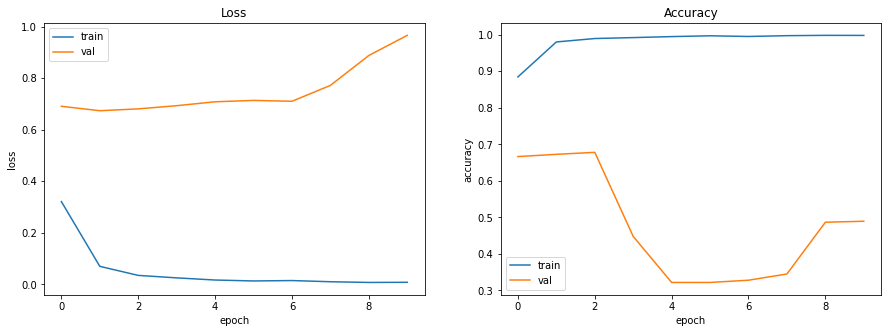

In [11]:
# 학습된 결과를 시각화를 통해 확인
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()

# 학습 결과 이상함 -> 코드 재확인 + 재학습시키기